![logo](../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# ERA5-Land temperature trend for climate change analysis

Production date: 20-07-2024

Produced by: Cristina Deidda (VUB)

## 🌍 Use case: Monitor climate change over Europe with land reanalysis data

## ❓ Quality assessment question
* **Are the monthly averaged temperature data from ERA5-Land suitable for recovering the trend of annual mean temperature increase in Spain in order to monitor climate change?**

**ERA5-Land dataset contains global reanalysis data with different level of aggregation: hourly and monthly average. One of the most analyzed variable provided is the "2m temperature". Temperature data are important to assess climatology and trends for climate change analysis. Study the climatology is becoming a topic always more essential to study for the increasing temperature due to global warming. In this use case, we want to check the feasibility of using directly ERA5-Land monthly averaged data to compute the average annual temperature trend at country level. We will focus on Spain considering the total length of data series available. To validate the analysis, we will compare it to the climatology statistical provided by Climate Change Knowledge Portal [[1]](https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historical).** 

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* ERA5-Land data show a statistically significant increasing trend of 0.04°C/year in annual mean temperature for Spain from 1997 to 2022.
* The trend is consistent with observed in-situ data from the Climate Knowledge Portal, which reports a similar trend of 0.03°C/year.
* ERA5-Land data tend to underestimate the annual mean temperature, particularly before 2015, due to a cold bias.
* Despite this cold bias, ERA5-Land data reproduce temperature trends well and are consistent with observed data.
* Similar findings of cold bias and trend consistency between ERA5-Land and observations have been reported in other regions, such as Turkey and China, indicating that ERA5-  Land is a reliable tool for temperature trend analysis across different geographic areas.
* ERA5-Land can be considered a valid substitute for in-situ observations in scientific research, despite its cold bias, especially for long-term temperature trend analysis.
```

Using ERA5-Land monthly data, we identified a statistically significant increasing trend of 0.04°C/year in the annual mean temperature for Spain from 1997 to 2022. This is consistent with the observed trend of 0.03°C/year obtained from in-situ data retrieved by the Climate Knowledge Portal [[1]](https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historical). However, the ERA5-Land data exhibit a cold bias, particularly before 2015, which leads to an underestimation of the annual mean temperature (Figure 1). 

```{figure} 697dfecb-6e88-42bb-bcf9-41a9b11a5623.png
---
height: 400px
---
Figure 1: Comparison between ERA5-Land and in-situ observations of annual temperature over Spain.
```

Similar findings have been reported in the literature. For example, Yilmaz (2023) [[2]](https://doi.org/10.1016/j.scitotenv.2022.159182) analyzed temperature trends in Turkey and found a high degree of consistency between the trends in ERA5/ERA5-Land and in-situ observations, suggesting that ERA5-Land may serve as a substitute for direct observations. Like our findings, Yilmaz observed a cold bias in ERA5-Land data compared to observations. Zhao and He (2022) [[3]](https://doi.org/10.3389/feart.2022.907730) found similar results in their study of the Qilian Mountains in China, where surface 2 m air temperature data from 17 meteorological stations (1979–2017) were compared to the ERA5-Land product. They reported a significant warming trend of 0.488°C/decade in the observed data, and ERA5-Land reanalysis captured the trend well at 0.379°C/decade. Again, a bias between ERA5-Land temperature and observations was noted. They concluded that ERA5-Land reliably reproduces temperature trends and is suitable for scientific research in the region.
Based on our findings and results from the literature, we suggest that ERA5-Land is suitable for detecting increasing trends for climate change analysis.

## 📋 Methodology

**[](reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-1)**
 * Download the 2m temperature variable (K) by selecting the boundary box of the Iberian Peninsula
 * Choose years of analysis: here we selected from 1997 to 2022
 * Convert units of measurement from Kelvin to Celsius
 * Define a function to clip the map using the Spain shapefile

**[](reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-2)**
 * Calculate the average annual temperature for the entire area
 * Create a bar plot grouped by year with annual temperature values
 * Analyze trends and significance using the Mann-Kendall Test
 * Compare with in-situ data

## 📈 Analysis and results

(reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-1)=
### 1. Set request and download

#### Import packages
Import c3s_eqc_automatic_quality_control library and packages to calculate the statistics.

In [19]:
import cartopy.crs as ccrs
import fsspec
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import shapely.geometry
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")

#### Set variables for request
Set the starting and ending year of analysis and url of Spain shapefile.

In [20]:
# Time
year_start = 1997
year_stop = 2022

# External files
shapefile_url = "https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/spain-shapefile/at_download/file"
observed_csv = (
    "observed-annual-average-mean-surface-air-temperature-of-spain-for-1901-2022.csv"
)

#### Set data request
Select the request, specifying the type of variable (monthly averaged reanalysis), variable (2m temperature) and the latitude and longitude coordinates for the Iberian Peninsula.

In [21]:
collection_id = "reanalysis-era5-land-monthly-means"
request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": "2m_temperature",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "time": "00:00",
    "area": [44, -10, 36, 0],
}

#### Download data and convert to Celsius
Download considering 1 year chuncks.

In [22]:
ds = download.download_and_transform(collection_id, request, chunks={"year": 1})
da = ds["t2m"]
with xr.set_options(keep_attrs=True):
    da -= 273.15
da.attrs["units"] = "°C"

100%|██████████| 26/26 [00:05<00:00,  5.15it/s]


#### Function to select and cut Spain map
Function to read Spain shapefile and cut the map.

In [23]:
def clip_shapefile(data, shapefile_url):
    shapefile_crs = "EPSG:4326"
    with fsspec.open(f"simplecache::{shapefile_url}") as file:
        gdf = gpd.read_file(file, layer="es_10km").to_crs(shapefile_crs)

    data = data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    data = data.rio.write_crs(shapefile_crs)
    data_clip = data.rio.clip(
        gdf.geometry.apply(shapely.geometry.mapping), gdf.crs, drop=False
    )
    return data_clip


da = clip_shapefile(da, shapefile_url)

(reanalysis_reanalysis-era5-land-monthly-means_climate-monitoring_q01:section-2)=
### 2. Results

#### Plot annual mean
Evaluation of the spatial annual mean and plot of the curve.

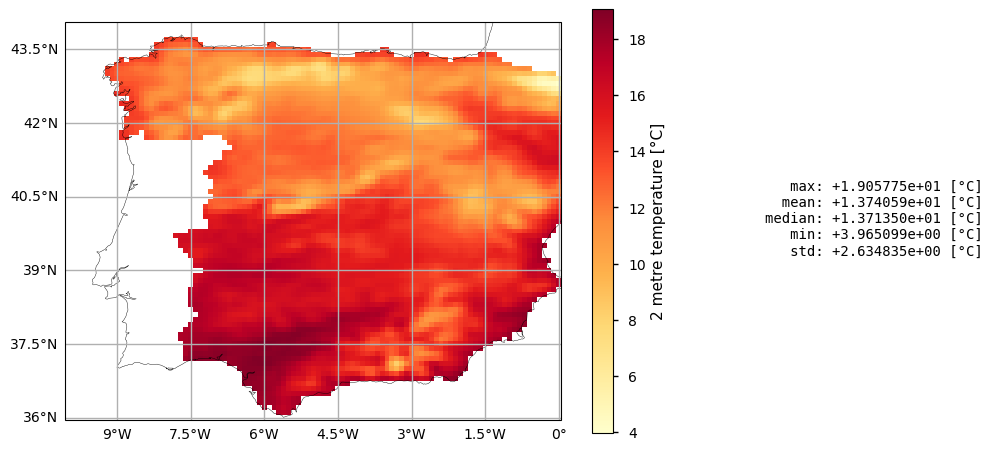

In [24]:
da_time_mean = diagnostics.time_weighted_mean(da)
plot.projected_map(
    da_time_mean.where(da_time_mean), projection=ccrs.PlateCarree(), cmap="YlOrRd"
)
_ = plt.title("")

#### Plot annual spatial mean
Calculate trend and significance with Mann Kendall Test and check for significance.

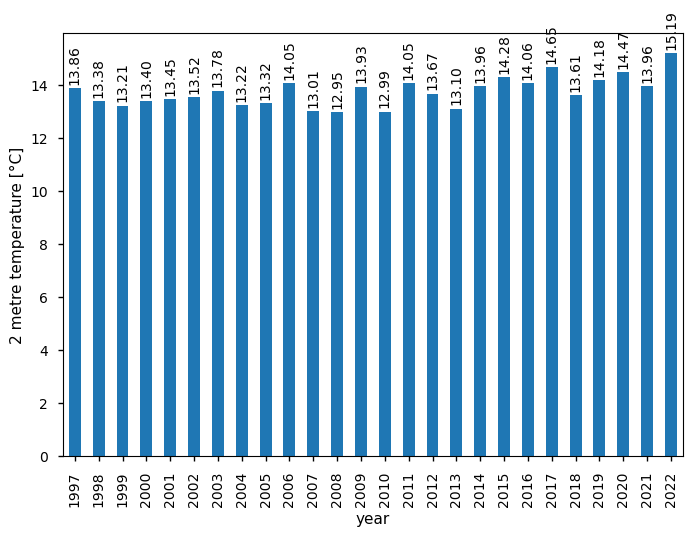

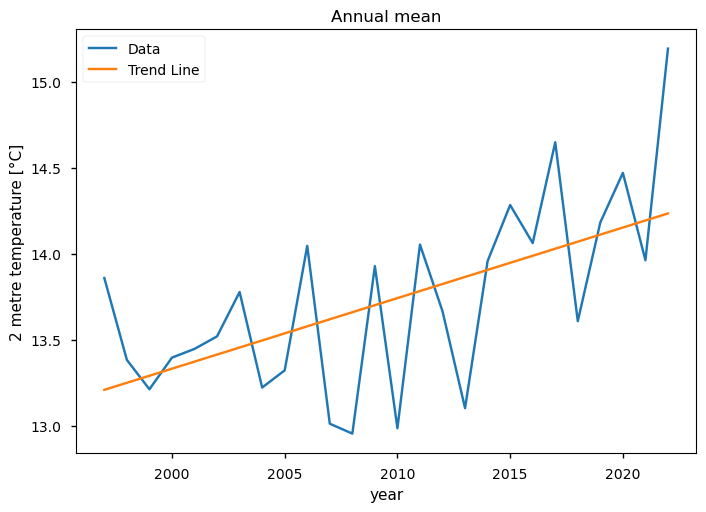

The trend is significant.
Trend: 0.041025 °C/year


In [25]:
da_spatial_mean = diagnostics.spatial_weighted_mean(da)
da_annual_mean = diagnostics.annual_weighted_mean(da_spatial_mean)
trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(da_annual_mean)

# Plot bars
ax = da_annual_mean.to_pandas().plot.bar()
ax.set_ylabel(f"{da_annual_mean.attrs['long_name']} [{da_annual_mean.attrs['units']}]")
ax.bar_label(ax.containers[0], rotation=90, fmt="%.2f", padding=2.5)
plt.show()

# Plot lines
da_annual_mean.plot(label="Data")
plt.plot(
    da_annual_mean["year"],
    np.arange(da_annual_mean.sizes["year"]) * slope + intercept,
    label="Trend Line",
)
plt.legend()
plt.title("Annual mean")
plt.show()

# Print significance
is_significant = p < 0.05
print(f"The trend is{'' if is_significant else ' NOT'} significant.")
print(f"Trend: {slope:f} {da_annual_mean.attrs['units']}/year")

Here, we plot the ERA5-Land 2 meter temperature annual mean from 1997 and 2022. Using Mann Kendall test we found a significant trend of 0.04 °C/year. 

#### Comparison with in-situ data
Import in-situ data and comparison with ERA5-Land data.

The observed trend is significant.
Trend: 0.027333 °C/year
Bias: -0.4921033702976487 °C/year


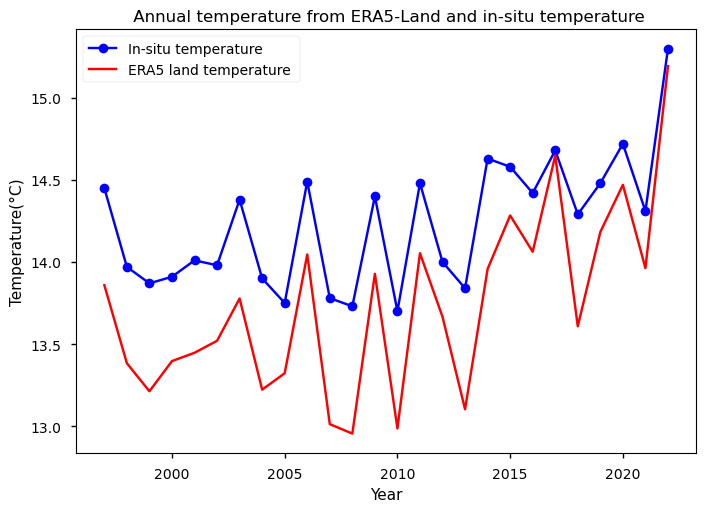

In [26]:
# Read the CSV file into a DataFrame
observed = pd.read_csv(observed_csv)
mask = (observed["Category"] >= year_start) & (observed["Category"] <= year_stop)
observed = observed[mask]

# Trend and significance
trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(
    observed["Annual Mean"]
)
is_significant = p < 0.05
print(f"The observed trend is{'' if is_significant else ' NOT'} significant.")
print(f"Trend: {slope:f} {da_annual_mean.attrs['units']}/year")

# bias
bias = np.mean(np.array(da_annual_mean - observed["Annual Mean"]))
print(f"Bias: {bias} {da_annual_mean.attrs['units']}/year")

# Plot the first line
plt.plot(
    observed["Category"],
    observed["Annual Mean"],
    label="In-situ temperature",
    color="blue",
    marker="o",
)

# Plot the second line
plt.plot(
    da_annual_mean["year"],
    da_annual_mean,
    label="ERA5 land temperature ",
    color="red",
    marker="x",
)

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Temperature(°C)")
plt.title(" Annual temperature from ERA5-Land and in-situ temperature")

# Add legend
plt.legend()

The Climate Knowledge Portal [[1]](https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historical) provides access to downloadable datasets, including a '.csv' file containing observed annual average surface air temperatures. This data is visualized on the portal's main page, where users can examine climate statistics for various countries. Here, we analyze the observed in-situ data for Spain. In the plot comparing two key datasets—ERA5-Land and in-situ observations—a significant warming trend is evident. Specifically, the ERA5-Land data shows a trend of 0.04°C per year, while in-situ measurements indicate a slightly lower trend of 0.03°C per year.

Additionally, the comparison reveals a consistent cold bias in ERA5-Land data relative to the observed values, particularly before 2015. After this point, the bias diminishes, suggesting an improvement in data accuracy. Despite the earlier cold bias, the overall warming trend is well captured by ERA5-Land, closely aligning with the in-situ observations.

## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historical) Climate Knowledge Portal, https://climateknowledgeportal.worldbank.org/country/spain/climate-data-historicaled (accessed on 17/09/2024).

[[2]](https://doi.org/10.1016/j.scitotenv.2022.159182) Yilmaz, M. (2023). Accuracy assessment of temperature trends from ERA5 and ERA5-Land. Science of the Total Environment, 856(Pt 2), 159182.

[[3]](https://doi.org/10.3389/feart.2022.907730) Zhao, Peng & He, Zhibin. (2022). A First Evaluation of ERA5-Land Reanalysis Temperature Product Over the Chinese Qilian Mountains. Frontiers in Earth Science. 10. 907730. 10.3389/feart.2022.907730. 
